## Evaluate the Annotations of Mismatching Translation Pairs
This is an evaluation script for the annotated mismatching translation pairs in the annotation experiment.

Recall the numbers:
- coupling: $\Gamma^{20000}_{\langle 1740, 1770 \rangle}$ (14031 pairs, 5835 mismatches)
- 2500 pairs in total (2x1500 pairs annotated, overlap: 500) 
- classes: 
    - O match (orthographic/morphological difference)
    - S match (semantically similar)
    - R mismatch (semantically related)
    - A mismatch (antonymy)
    - N mismatch (noise)
    - X mismatch (wildcard)
    
To do:
- compute inter-annotator agreement (Kohen's Kappa) _(0.44, 'moderate')_
- compute relative frequency of matches, mismatches _(matches/overlap: 0.722 (before) vs 0.728 (after annotation))_
- compute estimated quality of $\Gamma$ -- how much does it change compared match/mismatch statistics? _(not much)_
- make histogram of classes by score _(done)_
- make boxplot of classes _(done)_
- retrieve all pairs with labels O, S, R, and A

In [1]:
""" imports """
import utils
import default

import csv
import numpy as np
from pandas import DataFrame
import pandas as pd

from pprint import pprint

from sklearn.metrics import cohen_kappa_score

import matplotlib.pyplot as plt
%matplotlib inline

LABELS = ["O", "S", "R", "A", "N", "X"]

In [2]:
def read_annot_file(filepath):
    labels = []
    words1 = []
    words2 = []
    scores = []
    pairs  = []
    
    with open(filepath, "r") as f:
        for line in f:
            line = line.rstrip()
            if len(line) > 0:
                values = line.split()
                labels.append(values[0][1].upper()) # only the label, not the brackets
                words1.append(values[1])
                words2.append(values[2])
                pairs.append((values[1], values[2]))
                scores.append(float(values[3]))
            
    df = DataFrame({"label":labels, "word1":words1, "word2":words2, "pair":pairs, "score":scores})
    return df

def iaa(df1, df2, selection, label_name, selection_name):
    """ 
    this requires two dataframes, another dataframe to restrict the selection of labels (or None),
    and the column names of the labels and of the column to select by.
    """
    
    if selection is None:
        labels1 = df1[label_name].tolist()
        labels2 = df2[label_name].tolist() 
    else:
        labels1 = df1[df1[selection_name].isin(selection)][label_name].tolist()
        labels2 = df2[df2[selection_name].isin(selection)][label_name].tolist()

    return cohen_kappa_score(labels1, labels2)
        

#### Read the annotated files and compute the inter-annotator agreement. Then count the label frequencies

In [70]:
overlap_file = "annotation/pairs/overlap.txt"
annot1_file  = "annotation/annotated/annotations_1.txt" 
annot2_file  = "annotation/annotated/annotations_2.txt"

# read in all the data
overlap_pairs = set(read_annot_file(overlap_file)["pair"].tolist())
annot1 = read_annot_file(annot1_file)
annot2 = read_annot_file(annot2_file)

# compute inter-annotator agreement
agreement = iaa(annot1, annot2, overlap_pairs, "label", "pair")
print("agreement:",agreement)

# 0.45 is 'moderate agreement'

agreement: 0.44779224121292704


In [71]:
annot = pd.concat([annot1, annot2.loc[500:]]) # this does not have the indices right; you'll have to use .iloc[] instead of .loc[]

annot_ranked = annot.sort_values("score", ascending=False, ignore_index=True)
annot_ranked

,label,word1,word2,pair,score
0,N,thunder-clouds,reck,"(thunder-clouds, reck)",0.4322
1,N,elec,tric,"(elec, tric)",0.4218
2,N,half-complements,1000ths,"(half-complements, 1000ths)",0.4190
3,N,morbi,lateribus,"(morbi, lateribus)",0.4155
4,N,ibid,pt.,"(ibid, pt.)",0.4138
...,...,...,...,...,...
2495,N,littre,ptarmigan,"(littre, ptarmigan)",0.1253
2496,N,vermicles,alcyonia,"(vermicles, alcyonia)",0.1252
2497,N,touchstone,jargon,"(touchstone, jargon)",0.1252
2498,N,hoare,norton,"(hoare, norton)",0.1252


In [72]:
labels_O = annot[annot["label"]=="O"]
labels_S = annot[annot["label"]=="S"]
labels_R = annot[annot["label"]=="R"]
labels_A = annot[annot["label"]=="A"]
labels_N = annot[annot["label"]=="N"]
labels_X = annot[annot["label"]=="X"]
others = annot[annot["label"].isin(LABELS) == False]

for frame, label in zip([labels_O, labels_S, labels_R, labels_A, labels_N, labels_X], LABELS):
    print(f"label: {label}   frequency: {len(frame):>4}   {100*len(frame)/len(annot):>5.2f}%")

print(f"\nmislabelled:\n{others}")

label: O   frequency:   27    1.08%
label: S   frequency:   44    1.76%
label: R   frequency:  334   13.36%
label: A   frequency:   43    1.72%
label: N   frequency: 2032   81.28%
label: X   frequency:   17    0.68%

mislabelled:
     label     word1   word2                pair   score
764      M       bah     abf          (bah, abf)  0.1295
811      B  serenity  crotch  (serenity, crotch)  0.1286
1119     M      411/     63~         (411/, 63~)  0.1289


#### Pairs are distributed unevenly across coupling scores. Instead of plotting by score, plot by score rank instead.

/home/simon/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'occurrences')

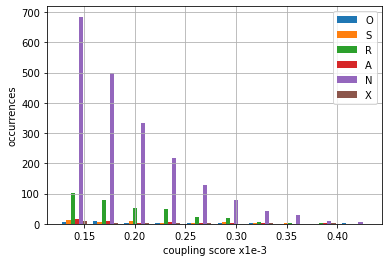

In [73]:
plt.hist([labels_O["score"].tolist(),
                labels_S["score"].tolist(),
                labels_R["score"].tolist(),
                labels_A["score"].tolist(),
                labels_N["score"].tolist(),
                labels_X["score"].tolist()],
                 label = LABELS,
               histtype = 'bar'
              )
plt.legend()
plt.grid()
plt.xlabel("coupling score x1e-3")
plt.ylabel("occurrences")

Text(0, 0.5, 'occurrences')

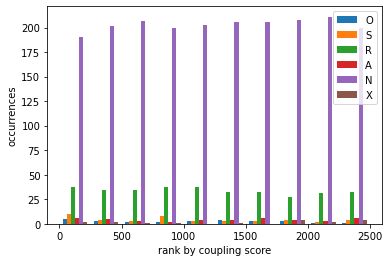

In [74]:
rlabels_O = annot_ranked[annot_ranked["label"]=="O"]
rlabels_S = annot_ranked[annot_ranked["label"]=="S"]
rlabels_R = annot_ranked[annot_ranked["label"]=="R"]
rlabels_A = annot_ranked[annot_ranked["label"]=="A"]
rlabels_N = annot_ranked[annot_ranked["label"]=="N"]
rlabels_X = annot_ranked[annot_ranked["label"]=="X"]
rothers = annot_ranked[annot_ranked["label"].isin(LABELS) == False]


plt.hist([rlabels_O.index.tolist(),
                rlabels_S.index.tolist(),
                rlabels_R.index.tolist(),
                rlabels_A.index.tolist(),
                rlabels_N.index.tolist(),
                rlabels_X.index.tolist()],
                 label = LABELS,
               histtype = 'bar'
              )
plt.legend()
plt.xlabel("rank by coupling score")
plt.ylabel("occurrences")


Text(0, 0.5, 'occurrences')

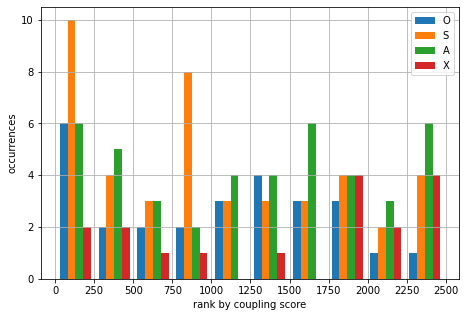

In [75]:
""" Exclude 'R' and 'N' to let the other labels show more nicely """

size_factor = 5
rows = 1
columns = 1

fig, axes = plt.subplots(rows, columns, figsize=(1.5*size_factor*columns, size_factor*rows))
                         


axes.hist([rlabels_O.index.tolist(),
           rlabels_S.index.tolist(),
           rlabels_A.index.tolist(),
           rlabels_X.index.tolist()],
           label = ["O", "S", "A", "X"],
           rwidth = 0.8,
           histtype = 'bar')
axes.legend()
axes.grid(which='both')
plt.xticks(range(0,2750,250), [str(x) for x in range(0,2750,250)])

axes.set_xlabel("rank by coupling score")
axes.set_ylabel("occurrences")
#plt.savefig("visuals/annotation_labels-hist.png", dpi=250)

Text(0, 0.5, 'rank by coupling score')

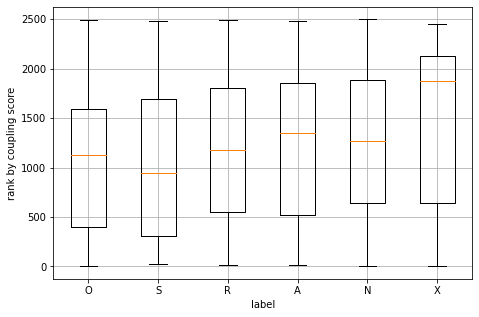

In [76]:
size_factor = 5
rows = 1
columns = 1

fig, axes = plt.subplots(rows, columns, figsize=(1.5*size_factor*columns, size_factor*rows))
                         


axes.boxplot([rlabels_O.index.tolist(),
                rlabels_S.index.tolist(),
                rlabels_R.index.tolist(),
                rlabels_A.index.tolist(),
                rlabels_N.index.tolist(),
                rlabels_X.index.tolist()],
                 labels = LABELS)

axes.grid(which='both')
axes.set_xlabel("label")
axes.set_ylabel("rank by coupling score")
#plt.savefig("visuals/annotation_label-ranks-boxplot.png", dpi=250)

#### Improvement of coupling performance

- label frequencies: O:27, S:44, R:334, A:43, N:2032, X:17, others:3
- 71 valuable (O, S)
- 2426 noise (R, A, N, X, others)

from the coupling:
- 14031 pairs  
- 11357 vocabulary overlap
- 8196 matches (5835 mismatches)
- matches/overlap: 0.722
- matches/pairs:   0.584

corrected:
- 8267 matches (5764 mismatches)
- matches/overlap: 0.728
- matches/pairs:   0.589

#### Write annotated pairs to a file (only those with the labels 'O' and 'S')

In [172]:
woi = {}
for frame in [labels_O, labels_S]:
    for p, s in zip(frame["pair"].tolist(), frame["score"].tolist()):
        woi[p] = s

In [176]:
filepath = "words_of_interest/1740_annotated_pairs.txt"
with open(filepath, "w") as f:
    for pair in sorted(woi, key=woi.get, reverse=True):
        #f.write(f"{pair[0]:<15} {pair[1]:<15} {woi[pair]:>5.3f}\n")